In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
token = {"username":"yf9761","key":"49473b3a8574a87b8e62f8b01f265d4b"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [ ]:
!cat /content/kaggle.json

{"username": "yf9761", "key": "49473b3a8574a87b8e62f8b01f265d4b"}

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [ ]:
!pwd

/content


In [ ]:
# 普通数据集的下载方式
# !kaggle datasets download -d slothkong/10-monkey-species

In [ ]:
# 比赛数据集的下载方式
!kaggle competitions download -c cifar-10

 99% 705M/715M [00:05<00:00, 126MB/s]
100% 715M/715M [00:05<00:00, 130MB/s]


# 新段落

In [ ]:
!ls /content/competitions/cifar-10

cifar-10.zip


In [ ]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [ ]:
!ls /content/

competitions  sample_data	    test.7z   trainLabels.csv
kaggle.json   sampleSubmission.csv  train.7z


In [ ]:
%pip install py7zr
import py7zr
a = py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.8 MB/s 
     |████████████████████████████████| 2.4 MB 11.4 MB/s 
     |████████████████████████████████| 2.3 MB 49.6 MB/s 
     |████████████████████████████████| 357 kB 42.1 MB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 138 kB 44.6 MB/s 


In [ ]:
!ls /content/competitions/cifar-10/train|wc -l

50000


In [ ]:
# 测试集
a = py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [ ]:
!ls /content/competitions/cifar-10/test|wc -l

300000


In [ ]:
!cp sampleSubmission.csv trainLabels.csv /content/competitions/cifar-10

In [ ]:
!ls /content/competitions/cifar-10

cifar-10.zip  sampleSubmission.csv  test  train  trainLabels.csv


In [ ]:
# 所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = 'competitions/cifar-10/trainLabels.csv'
test_csv_file = 'competitions/cifar-10/sampleSubmission.csv'
train_folder = 'competitions/cifar-10/train/'
test_folder = 'competitions/cifar-10/test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    # 读取所有行
    with open(filepath, 'r') as f:
        # lines = f.readlines()
        lines = f.readlines()[1:]  # 跳过第0行
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')  # strip()用于移除字符串头尾指定的字符或字符序列。
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))  # 使用flow_from_df要求这种格式
    return results 

# 解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
# 打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('competitions/cifar-10/train/1.png', 'frog'),
 ('competitions/cifar-10/train/2.png', 'truck'),
 ('competitions/cifar-10/train/3.png', 'truck'),
 ('competitions/cifar-10/train/4.png', 'deer'),
 ('competitions/cifar-10/train/5.png', 'automobile')]
[('competitions/cifar-10/test/1.png', 'cat'),
 ('competitions/cifar-10/test/2.png', 'cat'),
 ('competitions/cifar-10/test/3.png', 'cat'),
 ('competitions/cifar-10/test/4.png', 'cat'),
 ('competitions/cifar-10/test/5.png', 'cat')]
50000 300000


In [ ]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])  # 训练集
valid_df = pd.DataFrame(train_labels_info[45000:])  # 验证集
test_df = pd.DataFrame(test_csv_info)  # 测试集

train_df.columns = ['filepath', 'class']  # 给df赋列索引名
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                            filepath       class
0  competitions/cifar-10/train/1.png        frog
1  competitions/cifar-10/train/2.png       truck
2  competitions/cifar-10/train/3.png       truck
3  competitions/cifar-10/train/4.png        deer
4  competitions/cifar-10/train/5.png  automobile
                                filepath       class
0  competitions/cifar-10/train/45001.png       horse
1  competitions/cifar-10/train/45002.png  automobile
2  competitions/cifar-10/train/45003.png        deer
3  competitions/cifar-10/train/45004.png  automobile
4  competitions/cifar-10/train/45005.png    airplane
                           filepath class
0  competitions/cifar-10/test/1.png   cat
1  competitions/cifar-10/test/2.png   cat
2  competitions/cifar-10/test/3.png   cat
3  competitions/cifar-10/test/4.png   cat
4  competitions/cifar-10/test/5.png   cat


In [ ]:
!ls competitions/cifar-10/train/1.png

competitions/cifar-10/train/1.png


In [ ]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

# 训练集
train_generator = train_datagen.flow_from_dataframe(
    train_df,  # 这里放的是df，与之前不同
    directory = './',  # 目录，当前路径
    x_col = 'filepath',  # 特征的名字
    y_col = 'class',  # 标签的名字
    # 将标签转换为id
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',  # 因为类别是1，2，3...不是ont-hot编码，所以这里是sparse
)

# 验证集，和上面一致
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [ ]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128,  # 这里设的更大是为了从更多角度看图
              kernel_size=3, padding='same',
              activation='relu', 
              input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),  # 批归一化
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
              activation='relu'),  # 用relu为了模型训练的更快，用selu效果会更好
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
              activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
              activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
              activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
              activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",  # 因为前面是sparse
      optimizer="adam", 
      metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                        

In [ ]:
epochs = 20
history = model.fit(train_generator,
           steps_per_epoch = train_num // batch_size,
           epochs = epochs,
           validation_data = valid_generator,
           validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
1406/1406 [==============================] - 68s 38ms/step - loss: 1.8650 - accuracy: 0.3558 - val_loss: 1.7227 - val_accuracy: 0.4139
Epoch 2/20
1406/1406 [==============================] - 51s 36ms/step - loss: 1.4550 - accuracy: 0.4748 - val_loss: 1.1957 - val_accuracy: 0.5813
Epoch 3/20
1406/1406 [==============================] - 50s 36ms/step - loss: 1.2447 - accuracy: 0.5573 - val_loss: 1.5736 - val_accuracy: 0.5351
Epoch 4/20
1406/1406 [==============================] - 50s 36ms/step - loss: 1.0872 - accuracy: 0.6218 - val_loss: 0.8610 - val_accuracy: 0.7065
Epoch 5/20
1406/1406 [==============================] - 50s 36ms/step - loss: 0.9577 - accuracy: 0.6690 - val_loss: 0.8862 - val_accuracy: 0.7169
Epoch 6/20
1406/1406 [==============================] - 50s 36ms/step - loss: 0.8634 - accuracy: 0.7059 - val_loss: 0.9001 - val_accuracy: 0.7194
Epoch 7/20
1406/1406 [==============================] - 51s 36ms/step - loss: 0.7852 - accuracy: 0.7330 - val_loss: 0.6775 -

{'loss': [1.8649669885635376, 1.4550131559371948, 1.2446813583374023, 1.0872282981872559, 0.9576906561851501, 0.8633630871772766, 0.785202145576477, 0.7237411141395569, 0.6814003586769104, 0.6343750357627869, 0.6069622039794922, 0.5829338431358337, 0.5522756576538086, 0.5293101072311401, 0.5130939483642578, 0.4894617199897766, 0.4808277189731598, 0.46631884574890137, 0.4432668089866638, 0.4306395649909973], 'accuracy': [0.3558308184146881, 0.47482654452323914, 0.5573296546936035, 0.6217977404594421, 0.6689646244049072, 0.7058797478675842, 0.7330324053764343, 0.7530688643455505, 0.7690802216529846, 0.783579409122467, 0.7949653267860413, 0.8024150729179382, 0.8119773864746094, 0.8192492723464966, 0.8262764811515808, 0.8334148526191711, 0.8372620344161987, 0.8427548408508301, 0.8508050441741943, 0.8534736037254333], 'val_loss': [1.7226895093917847, 1.1957228183746338, 1.5735962390899658, 0.8610317707061768, 0.8861889839172363, 0.9000901579856873, 0.6774706840515137, 0.7250857949256897, 0.

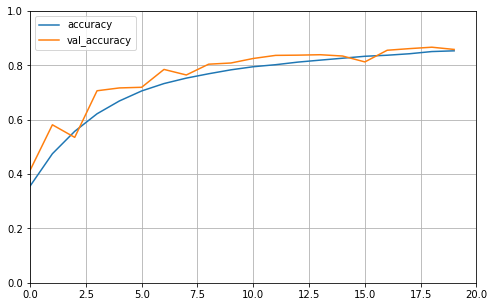

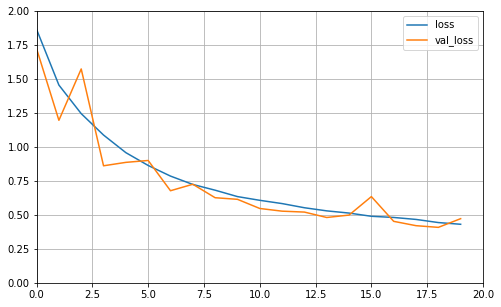

In [ ]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [ ]:
# 测试集
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [ ]:
test_predict = model.predict_generator(test_generator,
                     workers = 2,  # 获取batch时的“线程”并行数
                     use_multiprocessing = True  # 是否使用基于进程的线程
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [ ]:
print(test_predict.shape)

(300000, 10)


In [ ]:
# 每一个样本预测输出的是10个概率值
print(test_predict[0:5])

[[2.9825654e-03 4.8608057e-02 8.4211575e-03 1.8869705e-02 4.8231356e-02
  5.7584206e-03 7.2723660e-03 8.5549010e-03 5.5470476e-03 8.4575444e-01]
 [4.2291296e-01 2.9361260e-03 5.0616646e-01 2.0560015e-02 5.4331156e-03
  2.8564632e-03 2.1517325e-02 1.8680176e-03 1.2480187e-02 3.2693185e-03]
 [6.5588140e-10 9.7837454e-01 8.9828887e-11 8.8154803e-11 1.3022000e-10
  9.2986278e-12 3.7225209e-11 5.0626595e-12 2.0872630e-09 2.1625441e-02]
 [7.6473829e-05 1.5460106e-04 2.1332708e-06 1.3529681e-06 7.6818100e-07
  1.5457928e-07 2.0060052e-06 9.4226785e-08 9.9975914e-01 3.3613235e-06]
 [7.1585035e-01 4.1006489e-05 2.2374186e-01 4.7421562e-03 2.8799851e-03
  2.8631883e-03 2.4603202e-03 1.4794760e-03 4.5833930e-02 1.0761671e-04]]


In [ ]:
# 一个向量中谁的值最大，返回其下标
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [ ]:
print(test_predict_class_indices[0:5])

[9 2 1 8 0]


In [ ]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [ ]:
print(test_predict_class[0:5])

['truck', 'bird', 'automobile', 'ship', 'airplane']


In [ ]:
# 产生最终的报告
def generate_submissions(filename, predict_class):
  with open(filename, 'w') as f:
    f.write('id, label\n')
    for i in range(len(predict_class)):
      f.write('%d,%s\n' % (i+1, predict_class[i]))  # 类别是从1开始的，而range是从0开始的

output_file = "./submission.csv"
generate_submissions(output_file, test_predict_class)

In [ ]:
!ls

competitions  sample_data	    submission.csv  train.7z
kaggle.json   sampleSubmission.csv  test.7z	    trainLabels.csv
